In [153]:
from cmdstanpy import CmdStanModel
import arviz as az

import numpy as np
import matplotlib.pyplot as plt

dp_mix_stan = """
data
{
    int I; // number of areal locations
    int T; // number of time steps
    int P; // number of covariates
    int H; // truncation of stick breaking construction dp
    
    vector[I*T]     y; // output values
    matrix[I*T,P+1] X; // covariate matrix
    // syntax: y(i,t) = y[T*(i-1) + t]
    
    matrix[I,I] W_raw; // proximity matrix
      
    // hyperpar vector of regressors
    vector[P+1]     mu_0; 
    matrix[P+1,P+1] Sigma_0;
    
    // w_1
    vector[I] mu_w_1;
    
    // alpha
    real a_alpha;
    real b_alpha;
    
    // tau^2
    real a_tau2;
    real b_tau2;
    
    // sigma^2
    real a_sigma2;
    real b_sigma2;
    
    // rho
    real alpha_rho;
    real beta_rho;
    
    //xis
    real a_xi;
    real b_xi;
}

transformed data
{
    vector[T] ones_T;
    for (t in 1:T)
        ones_T[t] = 1;
    
    matrix[T,T] eye_T;
    eye_T = diag_matrix(ones_T);
 
    vector[I] ones_I;
    for (i in 1:I)
        ones_I[i] = 1;
    
    matrix[I,I] eye_I;
    eye_I = diag_matrix(ones_I);
        
    matrix[I,I] W;
    W = diag_matrix(W_raw*ones_I) - W_raw;
}

parameters
{
    real<lower=0> alpha;
    real<lower=0> sigma2;
    real<lower=0> tau2;
    real<lower=0,upper=1> rho;
    
    
    // autoregressive coefficients still to reparametrize
    vector<lower=0,upper=1>[I]    xis_constructors;
    
    // random effects
    matrix[T,I]                ws;
    
    // betas for the mixture of the dirichlet process
    matrix[P+1,H]              betas; 
    
    // for the construction of the dirichlet process
    vector<lower=0,upper=1>[H-1] vs;
}

transformed parameters
{   // weights stick breaking construction
    simplex[H] omegas; 
    
    // sbc stuff
    vector[H-1] cumprod_one_mv;    
    cumprod_one_mv = exp(cumulative_sum(log1m(vs)));
    
    omegas[1] = vs[1];
    omegas[2:(H-1)] = vs[2:(H-1)] .* cumprod_one_mv[1:(H-2)];
    omegas[H] = cumprod_one_mv[H-1];

}

model
{
    alpha  ~ gamma(a_alpha,b_alpha);
    sigma2 ~ inv_gamma(a_sigma2,b_sigma2);
    tau2   ~ inv_gamma(a_tau2,b_tau2);
    rho    ~ beta(alpha_rho,beta_rho);
    vs     ~ beta(1,alpha);
    vector[I] xis;
    for (i in 1:I){
        xis_constructors[i] ~ beta(a_xi,b_xi);
        xis[i]=2*xis_constructors[i]-1;
     }   
     
    matrix[I,I] inv_Q;
    inv_Q = inverse_spd(rho*W + (1-rho)*eye_I);
    
    ws[1,1:I] ~ multi_normal(mu_w_1, tau2*inv_Q);
    
    for (t in 2:T)
        ws[t,1:I] ~ multi_normal(ws[t-1,1:I]*diag_matrix(xis), tau2*inv_Q);
    
    for (h in 1:H)
        betas[1:P+1,h] ~ multi_normal(mu_0, Sigma_0);
        
    for (i in 1:I) {
        vector[H] log_probs;
        
        for (h in 1:H) 
            log_probs[h] = log(omegas[h]) + multi_normal_lpdf(y[T*(i-1)+1:i*T] | X[T*(i-1)+1:i*T, 1:P+1]*betas[1:P+1,h] + ws[1:T,i], sigma2*eye_T);
        
        target += log_sum_exp(log_probs);
    }
    matrix[I,H] log_probs;
    for (i in 1:I) 
    {
        for (h in 1:H) 
            log_probs[i,h] = log(omegas[h]) + multi_normal_lpdf(y[T*(i-1)+1:i*T] | X[T*(i-1)+1:i*T, 1:P+1]*betas[1:P+1,h]  + ws[1:T,i]  , sigma2*eye_T);
    
    }
}

generated quantities 
{   
    // vector of cluster allocations
    vector[I] s;
    
    matrix[I,H] log_probs;
    for (i in 1:I) 
    {
        for (h in 1:H) 
            log_probs[i,h] = log(omegas[h]) + multi_normal_lpdf(y[T*(i-1)+1:i*T] | X[T*(i-1)+1:i*T, 1:P+1]*betas[1:P+1,h]  + ws[1:T,i]  , sigma2*eye_T);
    
    }
    for (i in 1:I)
        s[i] = categorical_rng(softmax(log_probs[i,1:H]'));

    
}
"""

stan_file = "bayesian.stan"

with open(stan_file, "w") as fp:
    fp.write(dp_mix_stan)
    
dp_mix = CmdStanModel(stan_file=stan_file)

12:47:06 - cmdstanpy - INFO - compiling stan file /home/anna-ubuntu/bayesian-project/bayesian.stan to exe file /home/anna-ubuntu/bayesian-project/bayesian
12:49:07 - cmdstanpy - INFO - compiled model executable: /home/anna-ubuntu/bayesian-project/bayesian


[[1. 0. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 0. 1. 0. 1. 1. 1. 1.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 1. 1. 1. 0.]
 [1. 0. 1. 0. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0.]
 [0. 0. 0. 1. 1. 0. 1. 1. 0. 0. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0.]
 [1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 0. 0. 0. 1. 1. 0. 1. 1. 1. 1.]
 [1. 0. 1. 0. 1. 1. 0. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 0. 0.]
 [1. 0. 1. 1. 1. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1. 1. 1.]
 [1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 1. 1.]
 [1. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 1. 1. 0. 1. 1. 1. 0.]
 [0. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1.]
 [0. 1. 1. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0.]
 [1. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 0.]
 [1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 0. 1. 1. 0. 0. 0. 1. 1.]
 [1. 0. 1. 1. 1. 1. 0. 0. 1. 0. 0. 1. 1. 1. 1. 0. 0. 1. 0. 1.]
 [0. 0. 1. 0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0.

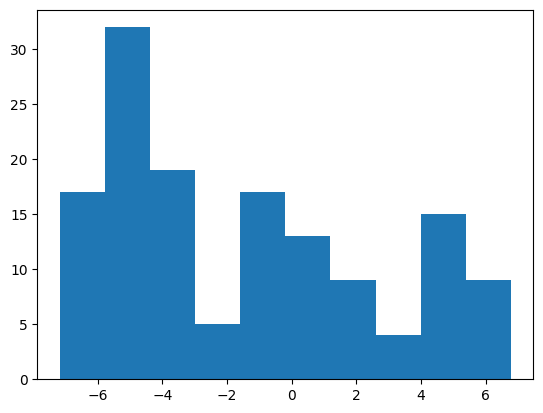

In [154]:
I = 20
T = 7
P = 3
means = np.array([-5, 0, 5]) #vector of possible mean 
y = np.zeros(I*T)
true_clus_allocs = np.zeros(I) #cluster of each areal allocation 
for i in range(1,I+1): #for each areal location 
    true_clus = np.random.choice(np.arange(3), size=1) #choose a cluster randomly between (1,2,3)
    true_clus_allocs[i-1] = true_clus #save the cluster choosen
    y[T*(i-1):T*i] = np.random.normal(loc=means[true_clus],size= T) #sample for all the time from the cluster choosen
    # this are the data related to areal i for all time until T
plt.hist(y)

X = np.ones((I*T,P+1)) # in this way the first column is made by one
for i in range(I*T):
   X[i,1:] = np.random.normal(loc=1,size= P) #the other P covariates are choosen randomly


mu_0 = np.zeros(P+1) #as in the paper
mu_w_1 = np.zeros(I) #as in the paper

W_raw = np.eye(I) #proximity matrix, ones in the diagonal, symm, just made by 1 or 0
for i in range(I):
    for j in range(i):
        W_raw[i,j] = np.random.binomial(size=1, n=1, p= 0.5) #choosen rand from a bernoulli
        W_raw[j,i] = W_raw[i,j] #it has to be symm
print(W_raw)

Sigma_0 = np.eye(P+1) #covariance matrix


data = {
    "I": I,
    "T": T,
    "P": P,
    "H": 10,
    "y": y,
    "X": X,
    "W_raw": W_raw,
    "mu_0": mu_0,
    "Sigma_0": Sigma_0,
    "mu_w_1": mu_w_1,
    "a_alpha": 3,
    "b_alpha": 2,
    "a_tau2": 3,
    "b_tau2": 2,
    "a_sigma2": 3,
    "b_sigma2": 2,
    "alpha_rho": 5,
    "beta_rho": 1,
    "a_xi": 1,
    "b_xi": 1
}

In [155]:
true_clus_allocs

array([1., 2., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 2., 0., 2.,
       2., 1., 0.])

In [156]:
fit = dp_mix.sample(data
#                     , show_console = True
#                    , chains=4
#                     , adapt_delta=0.9
#                    , step_size = 1.5
#                    , max_treedepth = 100
                   )

12:49:08 - cmdstanpy - INFO - CmdStan start processing




chain 1 |                                                        | 00:00 Status




chain 2 |                                                        | 00:00 Status





chain 3 |                                                        | 00:00 Status






chain 4 |                                                        | 00:00 Status






chain 4 |██▌                                                     | 00:00 Status





chain 3 |██▌                                                     | 00:00 Status




chain 2 |██▌                                                     | 00:00 Status



chain 1 |██▌                                                     | 00:00 Status





chain 3 |██                     | 01:44 Iteration:    1 / 2000 [  0%]  (Warmup)






chain 4 |██                     | 01:47 Iteration:    1 / 2000 [  0%]  (Warmup)



chain 1 |██                     | 01:56 Iteration:    1 / 2000 [  0%]  (Warmup)




chain 2 |█

chain 3 |████████████████▏    | 56:56 Iteration: 1400 / 2000 [ 70%]  (Sampling)




chain 2 |█████████████████▏   | 57:03 Iteration: 1500 / 2000 [ 75%]  (Sampling)






chain 4 |█████████████████▏   | 57:06 Iteration: 1500 / 2000 [ 75%]  (Sampling)



chain 1 |█████████████████▏   | 57:21 Iteration: 1500 / 2000 [ 75%]  (Sampling)




chain 2 |██████████████████▏  | 58:05 Iteration: 1600 / 2000 [ 80%]  (Sampling)






chain 4 |██████████████████▏  | 58:10 Iteration: 1600 / 2000 [ 80%]  (Sampling)



chain 1 |██████████████████▏  | 58:17 Iteration: 1600 / 2000 [ 80%]  (Sampling)





chain 3 |█████████████████▏   | 58:50 Iteration: 1500 / 2000 [ 75%]  (Sampling)




chain 2 |███████████████████  | 59:02 Iteration: 1700 / 2000 [ 85%]  (Sampling)






chain 4 |███████████████████  | 59:14 Iteration: 1700 / 2000 [ 85%]  (Sampling)



chain 1 |███████████████████  | 59:15 Iteration: 1700 / 2000 [ 85%]  (Sampling)




chain 2 |██████████████████▏| 1:00:00 Iteration: 1800 / 2000 [ 90%]  (Sa


13:52:24 - cmdstanpy - INFO - CmdStan done processing.
13:52:24 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: multi_normal_lpdf: Covariance matrix is not symmetric. Covariance matrix[1,3] = 2.23387e+08, but Covariance matrix[3,1] = 2.23387e+08 (in '/home/anna-ubuntu/bayesian-project/bayesian.stan', line 114, column 4 to column 49)
	Exception: multi_normal_lpdf: Covariance matrix is not symmetric. Covariance matrix[1,3] = 2.28912e+09, but Covariance matrix[3,1] = 2.28912e+09 (in '/home/anna-ubuntu/bayesian-project/bayesian.stan', line 114, column 4 to column 49)
	Exception: gamma_lpdf: Random variable is 0, but must be positive finite! (in '/home/anna-ubuntu/bayesian-project/bayesian.stan', line 100, column 4 to column 36)
Exception: multi_normal_lpdf: Covariance matrix is not symmetric. Covariance matrix[1,2] = -nan, but Covariance matrix[2,1] = -nan (in '/home/anna-ubuntu/bayesian-project/bayesian.stan', line 114, column 4 to column 49)
Exception: multi_normal_l

13:52:24 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 3 had 2 divergent transitions (0.2%)
	Use function "diagnose()" to see further information.


/home/anna-ubuntu/.local/lib/python3.10/site-packages/arviz/plots/traceplot.py:217: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (40), generating only 20 plots
  warnings.warn(


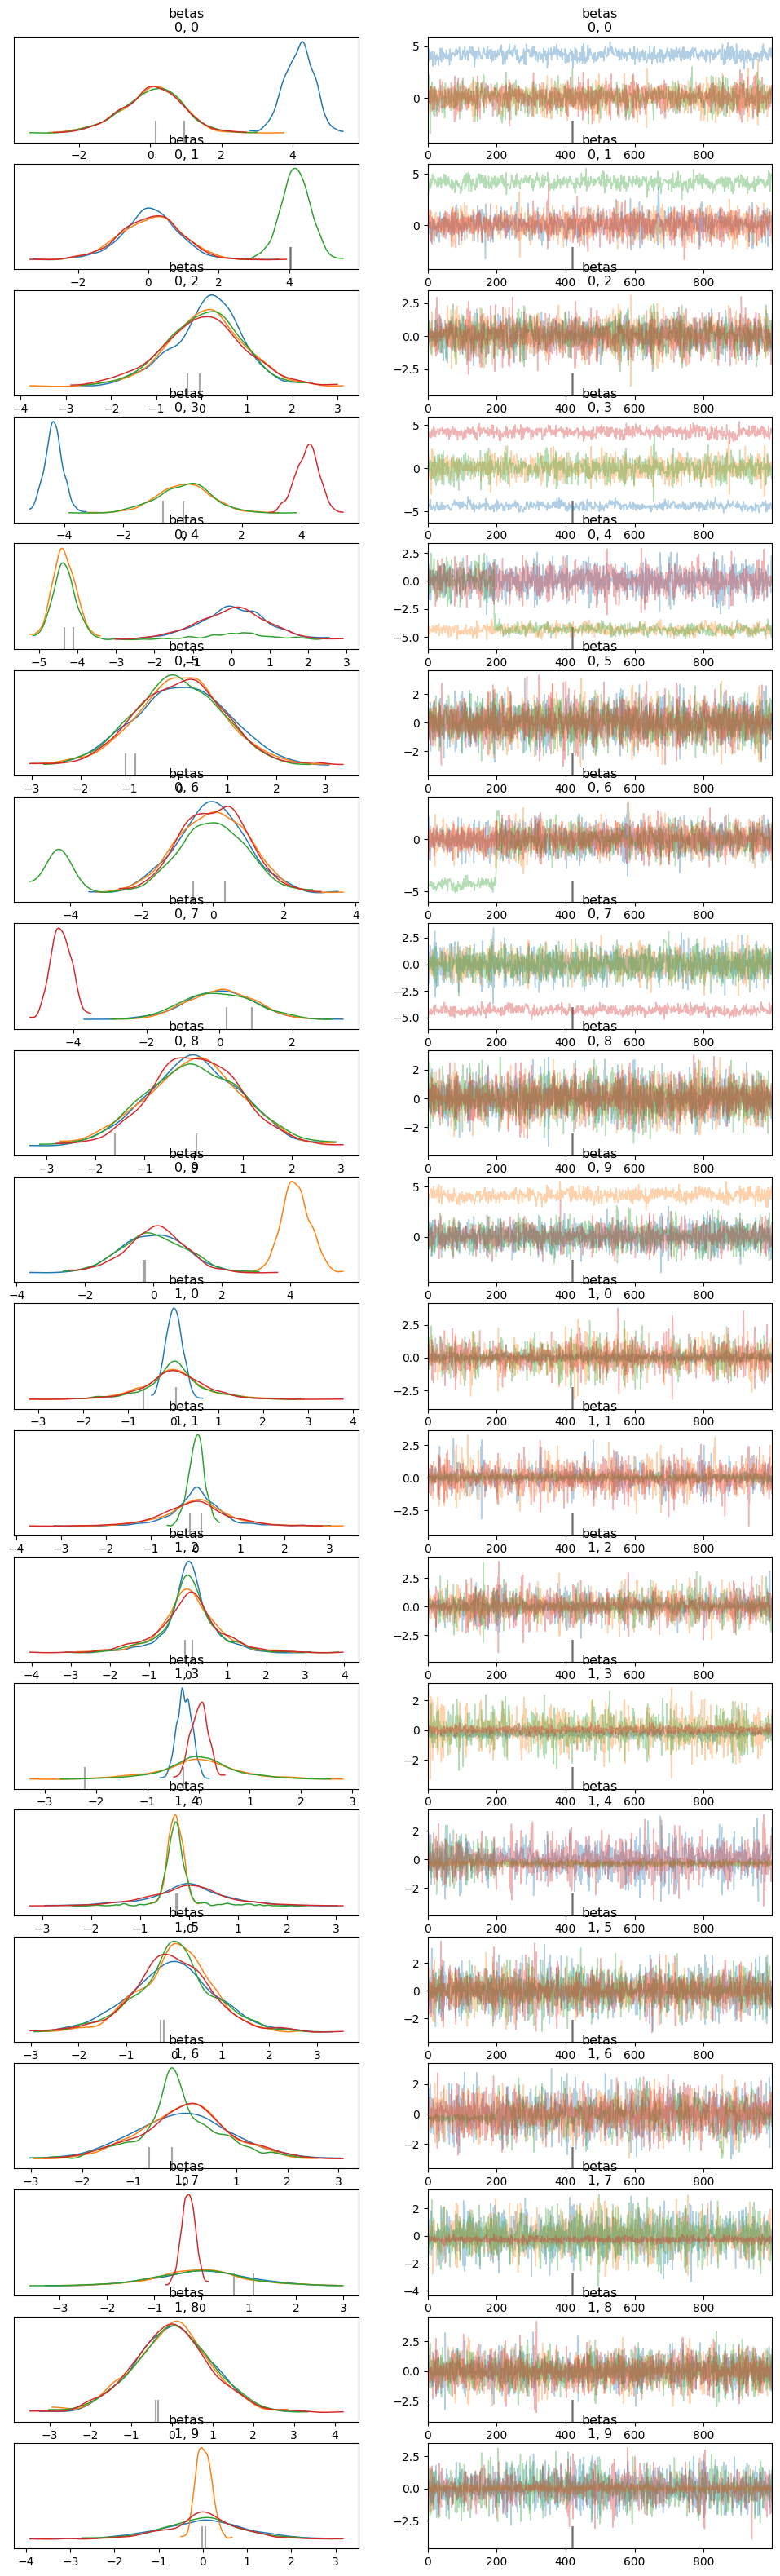

In [157]:
fit_az = az.from_cmdstanpy(fit)
az.plot_trace(fit, var_names=["betas"], compact=False)
plt.show()

In [158]:
fit.summary()

Mean       MCSE      StdDev          5%         50%  \
lp__             -225.408000   2.497700   31.249300 -276.644000 -224.682000   
alpha               2.231040   0.435414    1.033210    0.816942    2.072950   
sigma2              0.988711   0.005022    0.157933    0.745401    0.975088   
tau2                0.558234   0.017270    0.265565    0.259406    0.498450   
rho                 0.666965   0.006052    0.149368    0.389208    0.686391   
...                      ...        ...         ...         ...         ...   
log_probs[20,6]  -108.994000   1.042910   64.593800 -237.887000  -94.669100   
log_probs[20,7]  -105.216000   4.551980   69.444800 -237.546000  -90.056700   
log_probs[20,8]   -87.568700  33.122100   75.617200 -234.193000  -73.114300   
log_probs[20,9]  -114.332000   1.293400   71.567600 -260.483000  -96.059100   
log_probs[20,10] -167.331000  69.521100  115.045000 -378.603000 -121.002000   

                         95%       N_Eff   N_Eff/s     R_hat  
lp__             -176.025000   156.53100  0.058061  1.023500  
alpha               4.121700     5.63080  0.002089  1.229340  
sigma2              1.260300   988.96500  0.366831  1.006560  
tau2                1.045660   236.44800  0.087704  1.013490  
rho                 0.880563   609.09800  0.225929  1.004520  
...                      ...         ...       ...       ...  
log_probs[20,6]   -35.042700  3836.08000  1.422900  0.999951  
log_probs[20,7]   -18.187100   232.74400  0.086330  1.027170  
log_probs[20,8]   -10.788000     5.21201  0.001933  1.255080  
log_probs[20,9]   -34.485800  3061.74000  1.135670  1.000740  
log_probs[20,10]  -39.294200     2.73844  0.001016  1.851170  

[453 rows x 9 columns]

In [159]:
#Extimate pi[i,j] to compute Binder loss
#Likely not the most clever way to compute the matrix

n_chains=4
n_iteration_per_chain=1000
Binder_matrix= np.zeros((I,I))
for n in range(n_chains):
    for m in range(n_iteration_per_chain):
        for i in range(I):
            for j in range(i):
                if(i!=j and fit_az.posterior.s.values[n,m,i]==fit_az.posterior.s.values[n,m,j]):
                    Binder_matrix[i,j]+=1
                
Binder_matrix= Binder_matrix/(n_chains*n_iteration_per_chain)



In [160]:
#define Binder Loss

#Commented I added a penalty for a large number of clusters
#With penalty_n_clus=0 standard binder loss

def binder_function(binder_alloc):
    loss=0
    #penalty_n_clus=1
    #loss=penalty_n_clus*np.unique(binder_alloc).size
    
    for i in range(I):
        for j in range(i):
            
            if(binder_alloc[i]==binder_alloc[j]):
                    loss+=(1-Binder_matrix[i,j])**2
            
            else:
                loss+=(Binder_matrix[i,j])**2
            
    return loss

    

In [103]:
#Minimize Binder loss
# doesn't work with I big enough
#This solutions test every possibility and permutation
#it is likely to give a memory error

#import scipy
#max_n_clus=5
#ranges=[(0,max_n_clus-1)]*I
#scipy.optimize.brute(binder_function, ranges,  Ns=max_n_clus)

In [161]:
#Minimize Binder Loss evaluating the loss only 
#in the solutions found by stan model
#Not completly correct but should be a good doable approximation
n_chains=4
iteration_per_chain=1000
min_loss=10000
s_fixed=np.zeros(I)
for n in range(n_chains):
    for m in range(iteration_per_chain):
        loss=binder_function(fit_az.posterior.s.values[n,m])
        if(loss<min_loss):
            s_fixed=fit_az.posterior.s.values[n,m]

print('S_fixed')
print(s_fixed)

        
        

S_fixed
[1. 4. 8. 8. 1. 8. 8. 1. 8. 8. 2. 8. 8. 1. 4. 8. 4. 4. 1. 8.]


In [162]:
print('True clusters')
print(true_clus_allocs)

True clusters
[1. 2. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 2. 0. 2. 2. 1. 0.]


In [163]:
# Fixed clustering s to study betas depending on clusters
beta_clus_stan = """
data
{
    int<lower=1> I; // number of areal locations
    int<lower=1> T; // number of time steps
    int<lower=1> P; // number of covariates
    int<lower=1> H; // number of possible clusters
    
    vector[I*T]     y; // output values
    matrix[I*T,P+1] X; // covariate matrix
    // syntax: y(i,t) = y[T*(i-1) + t]
    
    matrix[I,I] W_raw; // proximity matrix
      
    // hyperpar vector of regressors
    vector[P+1]     mu_0; 
    matrix[P+1,P+1] Sigma_0;
    
    // w_1
    vector[I] mu_w_1;
    
    // alpha
    real<lower=0> a_alpha;
    real<lower=0> b_alpha;
    
    // tau^2
    real<lower=0> a_tau2;
    real<lower=0> b_tau2;
    
    // sigma^2
    real<lower=0> a_sigma2;
    real<lower=0> b_sigma2;
    
    // rho
    real<lower=0> alpha_rho;
    real<lower=0> beta_rho;
    
    //xis
    real<lower=0> a_xi;
    real<lower=0> b_xi;
    
    int s[I];
}

transformed data
{
    vector[T] ones_T;
    for (t in 1:T)
        ones_T[t] = 1;
    
    matrix[T,T] eye_T;
    eye_T = diag_matrix(ones_T);
 
    vector[I] ones_I;
    for (i in 1:I)
        ones_I[i] = 1;
    
    matrix[I,I] eye_I;
    eye_I = diag_matrix(ones_I);
        
    matrix[I,I] W;
    W = diag_matrix(W_raw*ones_I) - W_raw;
    
    
}

parameters
{
    real<lower=0> sigma2;
    real<lower=0> tau2;
    real<lower=0,upper=1> rho;
    
    
    // autoregressive coefficients still to reparametrize
    vector<lower=0,upper=1>[I]    xis_constructors;
    
    // random effects
    matrix[T,I]                ws;
    
   //Betas depend on clusters
    matrix[P+1,H]              betas_clus; 
    
    
}


model
{
    
    sigma2 ~ inv_gamma(a_sigma2,b_sigma2);
    tau2   ~ inv_gamma(a_tau2,b_tau2);
    rho    ~ beta(alpha_rho,beta_rho);
    
    
    xis_constructors ~ beta(a_xi,b_xi);
    vector[I] xis;
    xis = 2 * xis_constructors - 1; 
    matrix[I,I] inv_Q;
    inv_Q = inverse_spd(rho*W + (1-rho)*eye_I);
    
    ws[1,1:I] ~ multi_normal(mu_w_1, tau2*inv_Q);
    
    for (t in 2:T)
        ws[t,1:I] ~ multi_normal(ws[t-1,1:I]*diag_matrix(xis), tau2*inv_Q);
    
    for(h in 1:H)
    {
        betas_clus[1:P+1,h] ~ multi_normal(mu_0, Sigma_0);
    }
    for (i in 1:I){
        int clus_i=s[i]+1;
        
        y[T*(i-1)+1:i*T] ~ multi_normal(X[T*(i-1)+1:i*T, 1:P+1]*betas_clus[1:P+1,clus_i] + ws[1:T,i], sigma2*eye_T);
    }    
}

"""

stan_file = "beta_clus.stan"

with open(stan_file, "w") as fp:
    fp.write(beta_clus_stan)
    
beta_clus = CmdStanModel(stan_file=stan_file)

13:54:32 - cmdstanpy - INFO - compiling stan file /home/anna-ubuntu/bayesian-project/beta_clus.stan to exe file /home/anna-ubuntu/bayesian-project/beta_clus
13:56:03 - cmdstanpy - INFO - compiled model executable: /home/anna-ubuntu/bayesian-project/beta_clus
13:56:03 - cmdstanpy - WARNING - Stan compiler has produced 1 warnings:
13:56:03 - cmdstanpy - WARNING - 
--- Translating Stan model to C++ code ---
bin/stanc  --o=/home/anna-ubuntu/bayesian-project/beta_clus.hpp /home/anna-ubuntu/bayesian-project/beta_clus.stan
Warning in '/home/anna-ubuntu/bayesian-project/beta_clus.stan', line 42, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc

--- Compiling, linking C++ code ---
g++ -std=c++1y -pthread -D_REENTRANT -Wno-sign-compare -Wno-ignored-attributes      -I stan/lib/stan_math/lib/t

In [164]:
s= s_fixed.astype(int)

data_clus = {
    "I": I,
    "T": T,
    "P": P,
    "H": H,
    "y": y,
    "X": X,
    "W_raw": W_raw,
    "mu_0": mu_0,
    "Sigma_0": Sigma_0,
    "mu_w_1": mu_w_1,
    "a_alpha": 3,
    "b_alpha": 2,
    "a_tau2": 3,
    "b_tau2": 2,
    "a_sigma2": 3,
    "b_sigma2": 2,
    "alpha_rho": 5,
    "beta_rho": 1,
    "a_xi": 1,
    "b_xi": 1,
    "s":s
}


In [165]:
fit_clus = beta_clus.sample(data_clus
#                     , show_console = True
#                    , chains=4
#                     , adapt_delta=0.9
#                    , step_size = 1.5
#                    , max_treedepth = 100
                   )

13:56:03 - cmdstanpy - INFO - CmdStan start processing




chain 1 |                                                        | 00:00 Status




chain 2 |                                                        | 00:00 Status





chain 3 |                                                        | 00:00 Status






chain 4 |                                                        | 00:00 Status



chain 1 |██▌                                                     | 00:00 Status





chain 3 |██▌                                                     | 00:00 Status




chain 2 |██▌                                                     | 00:00 Status






chain 4 |██▌                                                     | 00:00 Status




chain 2 |██                     | 00:42 Iteration:    1 / 2000 [  0%]  (Warmup)






chain 4 |██                     | 00:44 Iteration:    1 / 2000 [  0%]  (Warmup)



chain 1 |██                     | 00:46 Iteration:    1 / 2000 [  0%]  (Warmup)





chain 3 |█

chain 3 |████████████████▏    | 05:39 Iteration: 1400 / 2000 [ 70%]  (Sampling)



chain 1 |█████████████████▏   | 05:49 Iteration: 1500 / 2000 [ 75%]  (Sampling)




chain 2 |██████████████████▏  | 05:51 Iteration: 1600 / 2000 [ 80%]  (Sampling)






chain 4 |█████████████████▏   | 05:55 Iteration: 1500 / 2000 [ 75%]  (Sampling)





chain 3 |█████████████████▏   | 06:01 Iteration: 1500 / 2000 [ 75%]  (Sampling)



chain 1 |██████████████████▏  | 06:05 Iteration: 1600 / 2000 [ 80%]  (Sampling)




chain 2 |███████████████████  | 06:06 Iteration: 1700 / 2000 [ 85%]  (Sampling)






chain 4 |██████████████████▏  | 06:13 Iteration: 1600 / 2000 [ 80%]  (Sampling)





chain 3 |██████████████████▏  | 06:17 Iteration: 1600 / 2000 [ 80%]  (Sampling)




chain 2 |████████████████████ | 06:22 Iteration: 1800 / 2000 [ 90%]  (Sampling)



chain 1 |███████████████████  | 06:25 Iteration: 1700 / 2000 [ 85%]  (Sampling)






chain 4 |███████████████████  | 06:32 Iteration: 1700 / 2000 [ 85%]  (S


14:03:02 - cmdstanpy - INFO - CmdStan done processing.
14:03:02 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: multi_normal_lpdf: Covariance matrix is not symmetric. Covariance matrix[1,4] = 7.26839e+07, but Covariance matrix[4,1] = 7.26839e+07 (in '/home/anna-ubuntu/bayesian-project/beta_clus.stan', line 101, column 4 to column 49)
	Exception: multi_normal_lpdf: Covariance matrix is not symmetric. Covariance matrix[1,7] = 9.82788e+09, but Covariance matrix[7,1] = 9.82788e+09 (in '/home/anna-ubuntu/bayesian-project/beta_clus.stan', line 101, column 4 to column 49)
	Exception: multi_normal_lpdf: Covariance matrix is not symmetric. Covariance matrix[1,2] = -nan, but Covariance matrix[2,1] = -nan (in '/home/anna-ubuntu/bayesian-project/beta_clus.stan', line 101, column 4 to column 49)
	Exception: multi_normal_lpdf: Covariance matrix is not symmetric. Covariance matrix[1,14] = 3.82177e+27, but Covariance matrix[14,1] = 3.82177e+27 (in '/home/anna-ubuntu/bayesian-proje

/home/anna-ubuntu/.local/lib/python3.10/site-packages/arviz/plots/traceplot.py:217: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (40), generating only 20 plots
  warnings.warn(


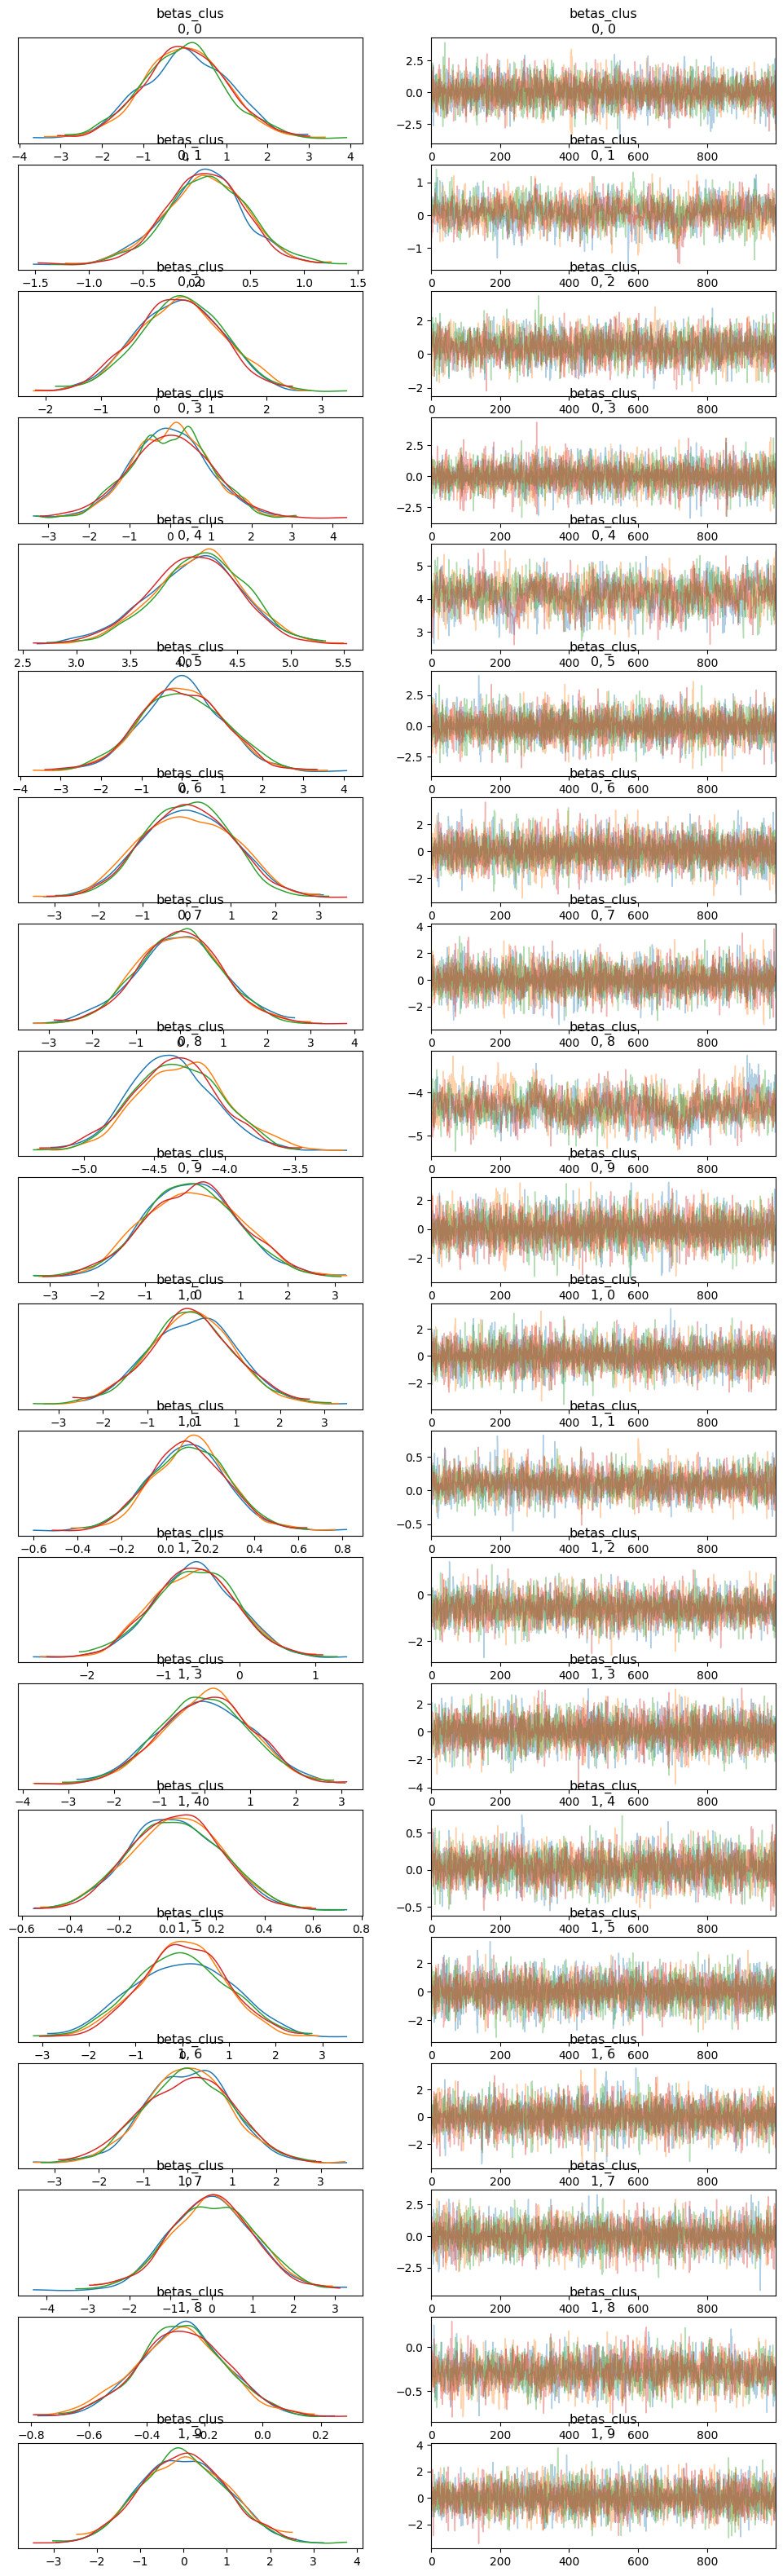

In [166]:
#betas[p,h] plot the betas specific to the clusters
fit_clus_az = az.from_cmdstanpy(fit_clus)
az.plot_trace(fit_clus, var_names=["betas_clus"], compact=False)
plt.show()


array([[<AxesSubplot: title={'center': 'betas_clus\n0, 0'}>,
        <AxesSubplot: title={'center': 'betas_clus\n0, 1'}>,
        <AxesSubplot: title={'center': 'betas_clus\n0, 2'}>,
        <AxesSubplot: title={'center': 'betas_clus\n0, 3'}>],
       [<AxesSubplot: title={'center': 'betas_clus\n0, 4'}>,
        <AxesSubplot: title={'center': 'betas_clus\n0, 5'}>,
        <AxesSubplot: title={'center': 'betas_clus\n0, 6'}>,
        <AxesSubplot: title={'center': 'betas_clus\n0, 7'}>],
       [<AxesSubplot: title={'center': 'betas_clus\n0, 8'}>,
        <AxesSubplot: title={'center': 'betas_clus\n0, 9'}>,
        <AxesSubplot: title={'center': 'betas_clus\n1, 0'}>,
        <AxesSubplot: title={'center': 'betas_clus\n1, 1'}>],
       [<AxesSubplot: title={'center': 'betas_clus\n1, 2'}>,
        <AxesSubplot: title={'center': 'betas_clus\n1, 3'}>,
        <AxesSubplot: title={'center': 'betas_clus\n1, 4'}>,
        <AxesSubplot: title={'center': 'betas_clus\n1, 5'}>],
       [<AxesSubplot

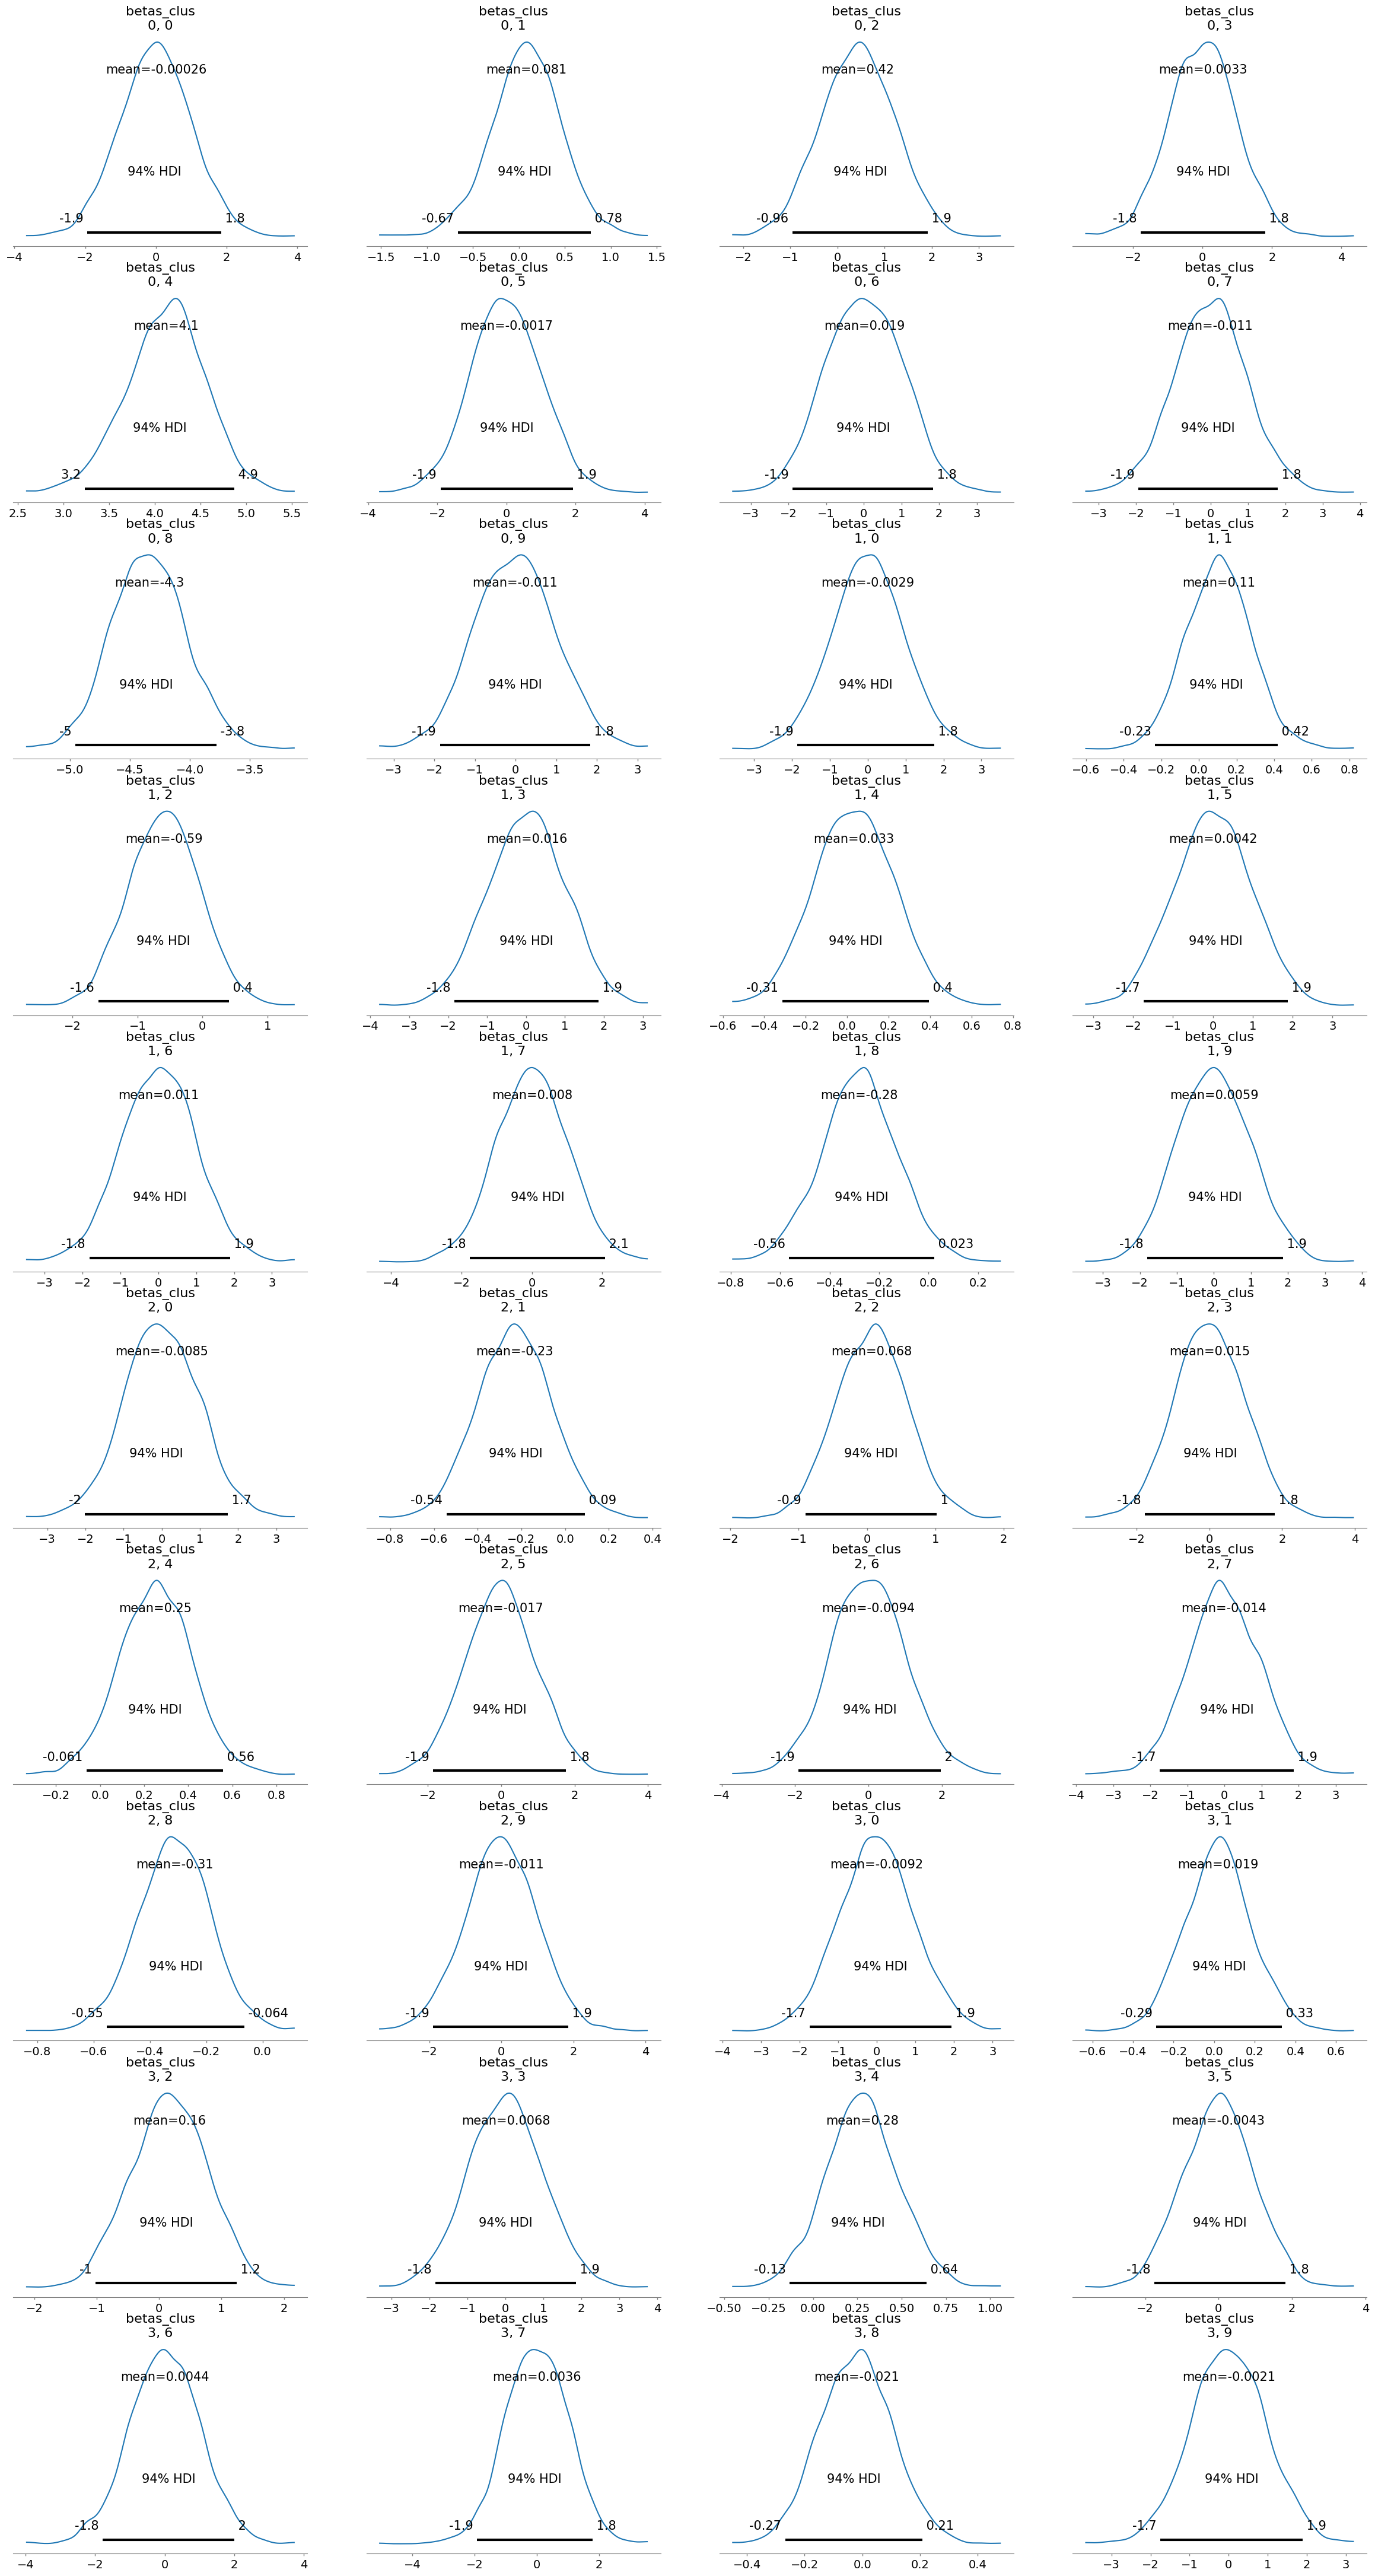

In [167]:
az.plot_posterior(fit_clus_az, var_names='betas_clus')

<AxesSubplot: >

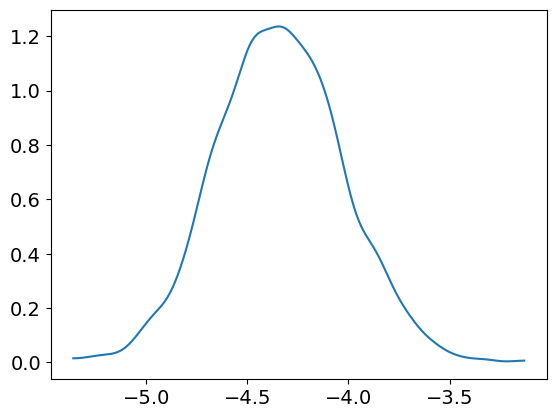

In [169]:
h=8   #plot the posterior of betas seen in cluster h

az.plot_dist(values=fit_clus_az.posterior.betas_clus.values[0:,0:,0,h])